In [1]:
usdjpy_filename = "usdjpy-m1.csv"

In [2]:
from forex_utils import DataPreprocessing

tool = DataPreprocessing()
raw_data = tool.load_csv(usdjpy_filename)

usdjpy-m1.csv 載入成功。


In [3]:
from forex_utils import FeatureEngineering

ef = FeatureEngineering()

# 設置參數
window_size = 8
test_size = 100

indi_df = ef.create_indicators(raw_data)
scal_df = ef.feature_scaling(indi_df)
feat_df, feature_size = ef.create_features(scal_df)
wind_df = ef.windowed(feat_df, window_size)


test_data = wind_df.tail(test_size)
train_data = wind_df.head(-test_size)

X_test = test_data.iloc[:, :window_size].tail(test_size)
y_test = test_data.y.tail(test_size).to_numpy()

# 提取訓練數據的特徵和標籤
X_train = train_data.iloc[:, :window_size]
y_train = train_data.iloc[:, -1:].to_numpy()

X_train = tool.prepare_sequence_data(X_train, window_size, feature_size)
X_test  = tool.prepare_sequence_data(X_test, window_size, feature_size)

Feature Engineering: (100529, 17)
feature_scaling    : (100476, 26)
Features & Lables  : (100476, 2)      Number of Features:  9
windowed Size = 8  : (100468, 9)
Reshaped Data: (100368, 8, 9)
Reshaped Data: (100, 8, 9)


In [4]:
import tensorflow as tf

def create_model(window_size, features, lay01 = 32, lay02 = 8, l2 = 0):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape = (window_size, features)),
      tf.keras.layers.LSTM(units = lay01, return_sequences = True, kernel_regularizer = tf.keras.regularizers.l2(l2)),
      tf.keras.layers.LSTM(units = lay02, kernel_regularizer = tf.keras.regularizers.l2(l2)),
      tf.keras.layers.Dense(1)
    ])

  return model

In [5]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
def initialize_plot(metrics):
  plt.ion()
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Loss")
  lines_dict = {metric: ax.plot([], [], label=metric)[0] for metric in metrics}
  losses_dict = {metric: [] for metric in metrics}

  ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.grid(True)
  ax.legend()
  return fig, ax, lines_dict, losses_dict

def on_epoch_end(epoch, logs, losses_dict, lines_dict, ax, fig):
  for key in losses_dict.keys():
    losses_dict[key].append(logs[key])
    lines_dict[key].set_xdata(range(epoch + 1))
    lines_dict[key].set_ydata(losses_dict[key])

  ax.relim()
  ax.autoscale_view()
  ax.legend()
  display(fig)
  clear_output(wait = True)

def create_plot_callback(metrics = ["loss"]):
  fig, ax, lines_dict, losses_dict = initialize_plot(metrics)
  callback = lambda epoch, logs: on_epoch_end(epoch, logs, losses_dict, lines_dict, ax, fig)

  return tf.keras.callbacks.LambdaCallback(on_epoch_end = callback)

KeyboardInterrupt: 

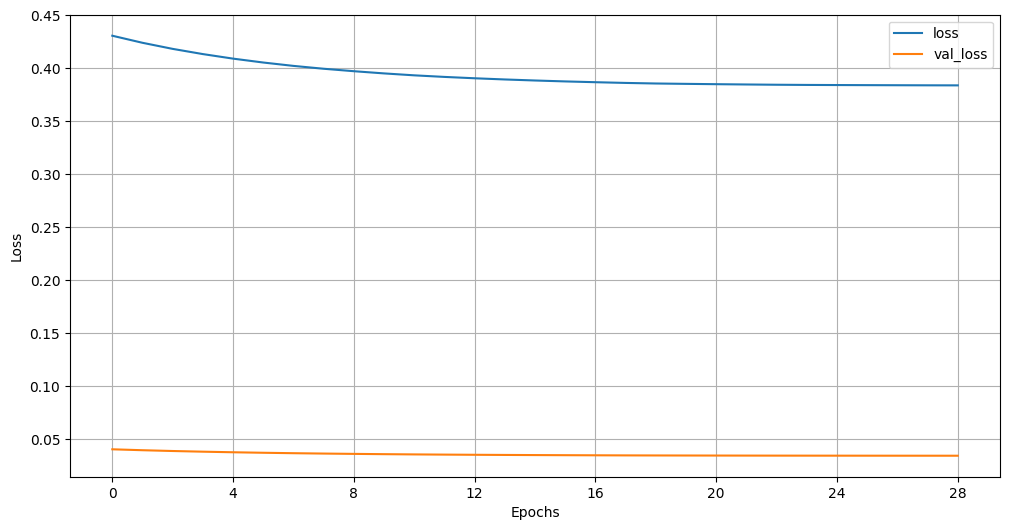

In [6]:


X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

initial_learning_rate=1e-7
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate,
decay_steps=400,
decay_rate=0.96,
staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model = create_model(window_size, feature_size)

model.compile(loss = "mse", optimizer = optimizer)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    restore_best_weights = True
    )


model.compile(loss = "mse", optimizer = optimizer)

plot_callback = create_plot_callback(["loss","val_loss"])
model.history = model.fit(X_train, y_train, batch_size = 64, epochs = 40, validation_split= 0.1,
                    callbacks = [plot_callback, early_stopping], verbose = 0)